#### Analysis of EURO-CORDEX annual data

- The CARMINE Euro-Cordex selected experiments have an impact on the climate indicators for the CARMINE CSAs in Europe
- This notebook is designed to quantify the uncertainties of the indicators for the CSAs and to provide communication material for stakeholders and scientific conferences

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Iterable, List

# Try to infer repository root from notebook location
# Assumes notebook is somewhere inside the repo
NOTEBOOK_DIR = Path.cwd()

# Heuristic: walk upwards until we find a marker (outputs/ or .git/)
def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / ".git").exists() or (p / "outputs").exists():
            return p
    return start

REPO_ROOT = find_repo_root(NOTEBOOK_DIR)

# ---- EURO-CORDEX testing paths ----
EUROCORDEX_TESTDATA_ROOT = REPO_ROOT / "2601_EURO_CORDEX_testing_data"
EUROCORDEX_TEST_UNZIP_ROOT = EUROCORDEX_TESTDATA_ROOT / "_unzipped"
EUROCORDEX_TEST_OUTPUT_ROOT = REPO_ROOT / "outputs" / "eurocordex_testing"

# Create directories (safe: ignored by git)
EUROCORDEX_TEST_UNZIP_ROOT.mkdir(parents=True, exist_ok=True)
EUROCORDEX_TEST_OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)

print("REPO_ROOT:", REPO_ROOT)
print("EUROCORDEX_TESTDATA_ROOT:", EUROCORDEX_TESTDATA_ROOT)
print("EUROCORDEX_TEST_UNZIP_ROOT:", EUROCORDEX_TEST_UNZIP_ROOT)
print("EUROCORDEX_TEST_OUTPUT_ROOT:", EUROCORDEX_TEST_OUTPUT_ROOT)

REPO_ROOT: C:\Users\reinhvlr\OneDrive\CARMINE-T2.4
EUROCORDEX_TESTDATA_ROOT: C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\2601_EURO_CORDEX_testing_data
EUROCORDEX_TEST_UNZIP_ROOT: C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\2601_EURO_CORDEX_testing_data\_unzipped
EUROCORDEX_TEST_OUTPUT_ROOT: C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\outputs\eurocordex_testing


In [2]:
# =============================================================================
# INVENTORY — scan unzipped EURO-CORDEX NetCDFs and build `df`
# (Run this BEFORE User Inputs + Catalog)
# =============================================================================
from __future__ import annotations

from pathlib import Path
import warnings

import pandas as pd
import xarray as xr


# --- where the unzipped NetCDFs live ---
UNZIP_ROOT = EUROCORDEX_TEST_UNZIP_ROOT
print("Scanning UNZIP_ROOT:", UNZIP_ROOT)

# --- discover files ---
nc_files = sorted([p for p in UNZIP_ROOT.rglob("*") if p.is_file() and p.suffix.lower() in (".nc", ".nc4", ".cdf")])
print(f"Found {len(nc_files)} NetCDF file(s)")

if not nc_files:
    warnings.warn("No NetCDFs found. Did the unzip cell run successfully?")

def _first_attr(ds: xr.Dataset, keys: list[str]) -> str | None:
    """Return the first non-empty global attribute found among keys."""
    for k in keys:
        if k in ds.attrs and ds.attrs.get(k) not in (None, ""):
            return str(ds.attrs.get(k))
    return None

rows: list[dict] = []

for fp in nc_files:
    row = {
        # file info
        "file_name": fp.name,
        "path": str(fp),
        "zip_folder": fp.parent.name,  # extracted zip stem folder
        "bytes": fp.stat().st_size,

        # quick structure
        "vars": None,
        "dims": None,

        # time summary
        "n_time": None,
        "time_start": None,
        "time_end": None,

        # origin / provenance (best-effort; may be None depending on provider)
        "institution": None,
        "source": None,
        "driving_model": None,
        "rcm_model": None,
        "ensemble_member": None,
        "experiment": None,
        "domain": None,
        "grid": None,
    }

    try:
        ds = xr.open_dataset(fp, decode_times=True)
        try:
            # structure
            row["vars"] = ",".join(list(ds.data_vars.keys()))
            row["dims"] = ",".join([f"{k}:{v}" for k, v in ds.sizes.items()])

            # time
            if "time" in ds.sizes:
                row["n_time"] = int(ds.sizes["time"])
            if "time" in ds.coords and ds.sizes.get("time", 0) > 0:
                # keep as string (works for cftime calendars too)
                row["time_start"] = str(ds["time"].values[0])
                row["time_end"] = str(ds["time"].values[-1])

            # provenance (common CF / CORDEX attrs)
            row["institution"] = _first_attr(ds, ["institution", "institute_id"])
            row["source"] = _first_attr(ds, ["source", "title"])
            row["driving_model"] = _first_attr(ds, ["driving_model_id", "driving_model"])
            row["rcm_model"] = _first_attr(ds, ["model_id", "rcm_model", "regional_model_id"])
            row["ensemble_member"] = _first_attr(ds, ["driving_model_ensemble_member", "ensemble_member", "realization"])
            row["experiment"] = _first_attr(ds, ["experiment_id", "scenario", "scenario_id"])
            row["domain"] = _first_attr(ds, ["domain_id", "CORDEX_domain"])
            row["grid"] = _first_attr(ds, ["grid", "grid_label"])

        finally:
            ds.close()

    except Exception as e:
        # keep the row but mark failure so users see it
        row["vars"] = "ERROR"
        row["dims"] = "ERROR"
        row["source"] = f"ERROR: {e}"

    rows.append(row)

# --- build df (THIS is what the catalog cell expects) ---
df = pd.DataFrame(rows)

# Show a compact view
key_cols = [
    "zip_folder", "file_name",
    "n_time", "time_start", "time_end",
    "experiment", "driving_model", "rcm_model", "ensemble_member",
    "institution", "domain", "grid",
    "vars", "dims",
]
key_cols = [c for c in key_cols if c in df.columns]

display(df[key_cols].sort_values(["zip_folder", "file_name"]).reset_index(drop=True))

print("\nInventory dataframe created: df")
print("df.shape:", df.shape)

Scanning UNZIP_ROOT: C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\2601_EURO_CORDEX_testing_data\_unzipped
Found 2 NetCDF file(s)


,zip_folder,file_name,n_time,time_start,time_end,experiment,driving_model,rcm_model,ensemble_member,institution,domain,grid,vars,dims
0,67a8bafca25cded2f165c94dc94b23ce,tas_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_KNMI-RAC...,120,2031-01-16 12:00:00,2040-12-16 12:00:00,rcp26,NCC-NorESM1-M,KNMI-RACMO22E,r1i1p1,"Royal Netherlands Meteorological Institute, De...",EUR-11,None,"rotated_pole,time_bnds,tas","time:120,bnds:2,rlat:412,rlon:424"
1,c7825f39aab277bfd373e79e60129936,tas_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_SMHI-...,120,2031-01-16T12:00:00.000000000,2040-12-16T12:00:00.000000000,rcp26,MPI-M-MPI-ESM-LR,SMHI-RCA4,r1i1p1,Swedish Meteorological and Hydrological Instit...,EUR-11,None,"time_bnds,tas,rotated_pole","time:120,bnds:2,rlat:412,rlon:424"



Inventory dataframe created: df
df.shape: (2, 17)


In [9]:
# =============================================================================
# USER INPUTS — EURO-CORDEX test workflow
# =============================================================================

# --- CSAs (panel order) ---
CSA_LIST = [
    "Barcelona",
    "Bologna",
    "Birmingham",
    "Leipzig",
    "Prague",
    "Funen-Odense",
    "Athens",
]

# --- Variable / indicator selection ---
# For your current test data:
VAR_NAME = "tas"   # 2m temperature (monthly mean)
# Later: "pr", "tasmax", derived indicators, etc.

# --- Model-chain selection ---
# Use None to include all available; otherwise filter by substring(s)
# (we will match against file_name and/or origin fields from the inventory)
MODEL_FILTERS = None
# Example:
# MODEL_FILTERS = ["NCC-NorESM1-M", "KNMI-RACMO22E"]

# --- Scenario / experiment selection ---
EXPERIMENT_FILTERS = None
# Example:
# EXPERIMENT_FILTERS = ["rcp26"]

# --- Which products to prepare later (not executed yet) ---
DO_MONTHLY_SINGLE = False
DO_ANNUAL_MEAN    = True
DO_PERIOD_MEAN    = True
DO_DIFF_MAPS      = False  # later

# Periods for period-mean products (YYYY, YYYY), inclusive
PERIODS = [
    (2031, 2040),
]

# --- user / project configuration ---
ADD_FUA_BOUNDARY = True

FUA_SHP_REL = Path("shapefile/UI-boundaries-FUA/FUA_Boundaries.shp")
FUA_NAME_FIELD = "FUA_NAME"

# Only needed if CSA folder names differ from FUA names
FUA_MAPPING = {
    "Prague": "Praha",
    "Funen-Odense": "Odense",
    "Athens": "Athina",
    "Birmingham": "West Midlands urban area",
}



print("CSA_LIST:", CSA_LIST)
print("VAR_NAME:", VAR_NAME)
print("MODEL_FILTERS:", MODEL_FILTERS)
print("EXPERIMENT_FILTERS:", EXPERIMENT_FILTERS)
print("PERIODS:", PERIODS)

CSA_LIST: ['Barcelona', 'Bologna', 'Birmingham', 'Leipzig', 'Prague', 'Funen-Odense', 'Athens']
VAR_NAME: tas
MODEL_FILTERS: None
EXPERIMENT_FILTERS: None
PERIODS: [(2031, 2040)]


In [10]:
# =============================================================================
# CATALOG — parse inventory into a tidy, filterable table
# =============================================================================
import re
import pandas as pd

# ---- REQUIREMENTS CHECK ----
assert "df" in globals(), "Inventory dataframe 'df' not found. Run the inventory cell first."

required_cols = {"file_name", "path"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Inventory df is missing required columns: {missing}")

cat = df.copy()

# ---- Parse variable + date range from filename (robust for EURO-CORDEX naming) ----
# Example:
# tas_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_KNMI-RACMO22E_v1_mon_203101-204012.nc
rx = re.compile(
    r"^(?P<var>[A-Za-z0-9]+)_"                 # tas
    r"(?P<domain>EUR-\d{2})_"                  # EUR-11
    r"(?P<gcm>[^_]+)_"                         # NCC-NorESM1-M
    r"(?P<exp>rcp\d{2})_"                      # rcp26
    r"(?P<member>r\d+i\d+p\d+)_"               # r1i1p1
    r"(?P<rcm>[^_]+)_"                         # KNMI-RACMO22E
    r".*?_mon_"                                # ..._mon_
    r"(?P<start>\d{6})-(?P<end>\d{6})"         # 203101-204012
)

def parse_from_filename(name: str) -> dict:
    m = rx.search(str(name))
    if not m:
        return {
            "var_fn": None, "domain_fn": None, "gcm_fn": None,
            "exp_fn": None, "member_fn": None, "rcm_fn": None,
            "start_ym": None, "end_ym": None
        }
    d = m.groupdict()
    return {
        "var_fn": d["var"],
        "domain_fn": d["domain"],
        "gcm_fn": d["gcm"],
        "exp_fn": d["exp"],
        "member_fn": d["member"],
        "rcm_fn": d["rcm"],
        "start_ym": d["start"],
        "end_ym": d["end"],
    }

parsed = cat["file_name"].apply(parse_from_filename).apply(pd.Series)
cat = pd.concat([cat, parsed], axis=1)

# ---- Build a stable model_chain_id (prefer inventory fields; fall back to filename parse) ----
def coalesce(a, b):
    return a if (a is not None and str(a).strip() != "" and str(a).lower() != "nan") else b

cat["gcm"] = cat.apply(lambda r: coalesce(r.get("driving_model"), r.get("gcm_fn")), axis=1)
cat["rcm"] = cat.apply(lambda r: coalesce(r.get("rcm_model"), r.get("rcm_fn")), axis=1)
cat["exp"] = cat.apply(lambda r: coalesce(r.get("experiment"), r.get("exp_fn")), axis=1)
cat["member"] = cat.apply(lambda r: coalesce(r.get("ensemble_member"), r.get("member_fn")), axis=1)
cat["var"] = cat.apply(lambda r: coalesce(r.get("var_fn"), None), axis=1)
cat["domain"] = cat.apply(lambda r: coalesce(r.get("domain"), r.get("domain_fn")), axis=1)

cat["model_chain_id"] = (
    cat["gcm"].fillna("NA") + "__" +
    cat["rcm"].fillna("NA") + "__" +
    cat["exp"].fillna("NA") + "__" +
    cat["member"].fillna("NA")
)

# ---- Basic filtering according to user inputs (still lightweight) ----
def match_any(val: str, patterns) -> bool:
    if patterns is None:
        return True
    s = str(val)
    return any(p.lower() in s.lower() for p in patterns)

# Filter by variable if we can
if "vars" in cat.columns and VAR_NAME:
    # keep if the dataset contains the variable, OR if filename indicates it
    cat = cat[
        cat["vars"].fillna("").str.contains(VAR_NAME, case=False, regex=False)
        | cat["file_name"].str.startswith(VAR_NAME + "_")
    ].copy()

# Filter by model/experiment patterns (against model_chain_id + file_name)
if MODEL_FILTERS is not None:
    cat = cat[cat.apply(lambda r: match_any(r["model_chain_id"], MODEL_FILTERS) or match_any(r["file_name"], MODEL_FILTERS), axis=1)].copy()

if EXPERIMENT_FILTERS is not None:
    cat = cat[cat.apply(lambda r: match_any(r["exp"], EXPERIMENT_FILTERS) or match_any(r["file_name"], EXPERIMENT_FILTERS), axis=1)].copy()

# ---- Show result (catalog) ----
show_cols = [
    "file_name", "var", "domain", "gcm", "rcm", "exp", "member",
    "start_ym", "end_ym", "n_time", "time_start", "time_end", "model_chain_id", "path"
]
show_cols = [c for c in show_cols if c in cat.columns]

print(f"Catalog rows after filtering: {len(cat)}")
display(cat[show_cols].sort_values(["model_chain_id", "start_ym", "file_name"]).reset_index(drop=True))

# Keep catalog available for later cells
catalog = cat


Catalog rows after filtering: 2


,file_name,var,domain,gcm,rcm,exp,member,start_ym,end_ym,n_time,time_start,time_end,model_chain_id,path
0,tas_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_SMHI-...,tas,EUR-11,MPI-M-MPI-ESM-LR,SMHI-RCA4,rcp26,r1i1p1,203101,204012,120,2031-01-16T12:00:00.000000000,2040-12-16T12:00:00.000000000,MPI-M-MPI-ESM-LR__SMHI-RCA4__rcp26__r1i1p1,C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\2601_E...
1,tas_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_KNMI-RAC...,tas,EUR-11,NCC-NorESM1-M,KNMI-RACMO22E,rcp26,r1i1p1,203101,204012,120,2031-01-16 12:00:00,2040-12-16 12:00:00,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\2601_E...


In [11]:
# =============================================================================
# CALCULATIONS — annual mean + period mean (bulk), saved as derived NetCDFs
# =============================================================================
from __future__ import annotations

from pathlib import Path
import xarray as xr
import pandas as pd

assert "catalog" in globals(), "catalog not found. Run the catalog cell first."

DERIVED_ROOT = EUROCORDEX_TEST_OUTPUT_ROOT / "derived"
DERIVED_ROOT.mkdir(parents=True, exist_ok=True)

FORCE_RECALC = False  # set True to overwrite derived files

def safe_slug(s: str) -> str:
    return "".join(ch if ch.isalnum() or ch in ("-", "_") else "_" for ch in str(s))

def open_var(path: str | Path, var_name: str) -> xr.DataArray:
    """Open NetCDF and return selected variable as a loaded DataArray (safe to close file)."""
    path = Path(path)
    with xr.open_dataset(path, decode_times=True) as ds:
        if var_name in ds:
            da = ds[var_name]
        else:
            da = ds[list(ds.data_vars)[0]]  # fallback
        da = da.squeeze().load()  # load so we can close the file safely
    da.name = var_name
    return da

def annual_mean(da: xr.DataArray) -> xr.DataArray:
    """Monthly → annual mean (calendar-year), robust for cftime calendars."""
    if "time" not in da.dims:
        raise ValueError("No 'time' dimension found.")
    return da.groupby(da["time"].dt.year).mean("time", skipna=True)

def period_mean(da: xr.DataArray, y1: int, y2: int) -> xr.DataArray:
    """Mean over years y1..y2 inclusive, robust for cftime calendars."""
    if "time" not in da.dims:
        raise ValueError("No 'time' dimension found.")
    years = da["time"].dt.year
    da_sel = da.sel(time=(years >= y1) & (years <= y2))
    return da_sel.mean("time", skipna=True)

def write_ds(da: xr.DataArray, out_path: Path):
    """Write DataArray as a single-variable Dataset NetCDF."""
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    da.to_dataset(name=da.name).to_netcdf(out_path)

results = []

for _, row in catalog.iterrows():
    fp = Path(row["path"])
    if not fp.exists():
        print("Skip missing:", fp)
        continue

    model_id = safe_slug(row.get("model_chain_id", "NA"))
    start_ym = row.get("start_ym", "NA")
    end_ym = row.get("end_ym", "NA")

    da = open_var(fp, VAR_NAME)

    # --- Annual mean ---
    if DO_ANNUAL_MEAN:
        outdir = DERIVED_ROOT / "annual_mean" / model_id
        out_path = outdir / f"{VAR_NAME}_annualmean_{start_ym}-{end_ym}.nc"

        if FORCE_RECALC or not out_path.exists():
            ann = annual_mean(da)
            write_ds(ann, out_path)

        results.append({
            "product": "annual_mean",
            "model_chain_id": row.get("model_chain_id"),
            "in_file": fp.name,
            "out_file": out_path.name,
            "out_path": str(out_path),
        })

    # --- Period mean(s) ---
    if DO_PERIOD_MEAN:
        outdir = DERIVED_ROOT / "period_mean" / model_id

        for (y1, y2) in PERIODS:
            out_path = outdir / f"{VAR_NAME}_periodmean_{y1}-{y2}_{start_ym}-{end_ym}.nc"

            if FORCE_RECALC or not out_path.exists():
                pm = period_mean(da, y1, y2)
                write_ds(pm, out_path)

            results.append({
                "product": f"period_mean_{y1}-{y2}",
                "model_chain_id": row.get("model_chain_id"),
                "in_file": fp.name,
                "out_file": out_path.name,
                "out_path": str(out_path),
            })

results_df = pd.DataFrame(results)
display(results_df)
print("Derived root:", DERIVED_ROOT)


,product,model_chain_id,in_file,out_file,out_path
0,annual_mean,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,tas_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_KNMI-RAC...,tas_annualmean_203101-204012.nc,C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\output...
1,period_mean_2031-2040,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,tas_EUR-11_NCC-NorESM1-M_rcp26_r1i1p1_KNMI-RAC...,tas_periodmean_2031-2040_203101-204012.nc,C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\output...
2,annual_mean,MPI-M-MPI-ESM-LR__SMHI-RCA4__rcp26__r1i1p1,tas_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_SMHI-...,tas_annualmean_203101-204012.nc,C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\output...
3,period_mean_2031-2040,MPI-M-MPI-ESM-LR__SMHI-RCA4__rcp26__r1i1p1,tas_EUR-11_MPI-M-MPI-ESM-LR_rcp26_r1i1p1_SMHI-...,tas_periodmean_2031-2040_203101-204012.nc,C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\output...


Derived root: C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\outputs\eurocordex_testing\derived


In [14]:
# =============================================================================
# TABLE OUTPUT — run CSA aggregation for all derived products and write CSV
# =============================================================================
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import warnings

# requires: CSA_LIST, results_df, VAR_NAME, load_fua_boundary, EUROCORDEX_TEST_OUTPUT_ROOT

TABLES_DIR = EUROCORDEX_TEST_OUTPUT_ROOT / "tables"
TABLES_DIR.mkdir(parents=True, exist_ok=True)

def get_lon_lat_from_da(da: xr.DataArray):
    for lon, lat in [("lon","lat"), ("longitude","latitude"), ("LON","LAT"), ("nav_lon","nav_lat")]:
        if lon in da.coords and lat in da.coords:
            return da[lon].values, da[lat].values
    return None, None

def mask_from_polygon(lon, lat, polygon):
    from shapely import vectorized
    if lon.ndim == 1 and lat.ndim == 1:
        xx, yy = np.meshgrid(lon, lat)
        return vectorized.contains(polygon, xx, yy)
    return vectorized.contains(polygon, lon, lat)

def csa_means_from_derived(out_path: Path, model_chain_id: str, product: str) -> list[dict]:
    out_path = Path(out_path)
    rows = []

    ds = xr.open_dataset(out_path, decode_times=True)
    try:
        da = ds[VAR_NAME].squeeze()

        lon, lat = get_lon_lat_from_da(da if "year" not in da.dims else da.isel(year=0))
        if lon is None or lat is None:
            warnings.warn(f"Skip (no lon/lat coords): {out_path.name}")
            return rows

        # iterate annual years if present; else single map
        if "year" in da.dims:
            year_vals = [int(y) for y in da["year"].values]
            slices = [(y, da.sel(year=y)) for y in year_vals]
        else:
            slices = [(None, da)]

        for year_val, da2 in slices:
            arr = np.asarray(da2.values, dtype="float64")

            for csa in CSA_LIST:
                gdf = load_fua_boundary(csa)
                if gdf is None or gdf.empty:
                    warnings.warn(f"No FUA geometry for CSA={csa}")
                    continue

                bg = gdf
                if getattr(bg, "crs", None) is not None:
                    bg = bg.to_crs("EPSG:4326")

                # dissolve to one polygon (GeoPandas >= 0.14)
                poly = bg.geometry.union_all()

                m = mask_from_polygon(lon, lat, poly)
                if m.shape != arr.shape:
                    warnings.warn(f"Skip CSA={csa} (mask shape {m.shape} != data {arr.shape}) for {out_path.name}")
                    continue

                n_cells = int(np.sum(m))
                mean_val = float(np.nanmean(arr[m])) if n_cells > 0 else np.nan

                rows.append({
                    "csa": csa,
                    "model_chain_id": model_chain_id,
                    "product": product,
                    "year": year_val,
                    "mean": mean_val,
                    "n_cells": n_cells,
                    "derived_file": out_path.name,
                })

    finally:
        ds.close()

    return rows


# ---- run across ALL derived outputs (annual + period) ----
all_rows = []
for _, r in results_df.iterrows():
    out_path = Path(r["out_path"])
    if not out_path.exists():
        warnings.warn(f"Missing derived output: {out_path}")
        continue

    all_rows.extend(
        csa_means_from_derived(
            out_path=out_path,
            model_chain_id=r.get("model_chain_id"),
            product=r.get("product"),
        )
    )

tables_df = pd.DataFrame(all_rows)

# tidy: add a period column (only for period means)
tables_df["period"] = None
mask_period = tables_df["product"].astype(str).str.startswith("period_mean_")
tables_df.loc[mask_period, "period"] = tables_df.loc[mask_period, "product"].str.replace("period_mean_", "", regex=False)
# annual: year is set, period stays None

display(tables_df.head(20))
print("Rows:", len(tables_df))

# ---- write outputs ----
csv_path = TABLES_DIR / f"CSA_FUA_means_{VAR_NAME}.csv"
tables_df.to_csv(csv_path, index=False)
print("Wrote:", csv_path)

# Optional: a wide pivot for quick inspection (one table per product)
wide = tables_df.pivot_table(index=["csa"], columns=["product", "model_chain_id", "year"], values="mean")
display(wide)


,csa,model_chain_id,product,year,mean,n_cells,derived_file,period
0,Barcelona,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2031.0,286.502524,13,tas_annualmean_203101-204012.nc,None
1,Bologna,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2031.0,285.658722,13,tas_annualmean_203101-204012.nc,None
2,Birmingham,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2031.0,282.502340,13,tas_annualmean_203101-204012.nc,None
3,Leipzig,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2031.0,282.763519,26,tas_annualmean_203101-204012.nc,None
4,Prague,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2031.0,281.933567,46,tas_annualmean_203101-204012.nc,None
5,Funen-Odense,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2031.0,282.444324,26,tas_annualmean_203101-204012.nc,None
6,Athens,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2031.0,290.185025,20,tas_annualmean_203101-204012.nc,None
7,Barcelona,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2032.0,286.639292,13,tas_annualmean_203101-204012.nc,None
8,Bologna,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2032.0,285.188570,13,tas_annualmean_203101-204012.nc,None
9,Birmingham,NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1,annual_mean,2032.0,282.286177,13,tas_annualmean_203101-204012.nc,None


Rows: 154
Wrote: C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\outputs\eurocordex_testing\tables\CSA_FUA_means_tas.csv


product                                       annual_mean              \
model_chain_id MPI-M-MPI-ESM-LR__SMHI-RCA4__rcp26__r1i1p1               
year                                               2031.0      2032.0   
csa                                                                     
Athens                                         290.431100  289.947882   
Barcelona                                      287.613626  287.582069   
Birmingham                                     282.693965  282.587823   
Bologna                                        288.233349  288.338050   
Funen-Odense                                   282.732227  282.325704   
Leipzig                                        283.820384  283.113464   
Prague                                         283.181579  282.721593   

product                                                                     \
model_chain_id                                                               
year                2033.0      2034.0      2035.0      2036.0      2037.0   
csa                                                                          
Athens          289.524170  290.203352  290.746362  289.370282  290.443498   
Barcelona       288.445247  288.690660  288.334480  287.570082  287.640200   
Birmingham      283.753155  283.611706  283.399116  282.276891  282.934556   
Bologna         288.880383  289.731354  289.276046  287.847701  288.616089   
Funen-Odense    282.883669  283.200959  283.060285  282.253821  283.066670   
Leipzig         284.077006  284.967096  284.223760  283.240645  284.043110   
Prague          283.431366  284.345302  283.750872  282.669459  283.519569   

product                                             \
model_chain_id                                       
year                2038.0      2039.0      2040.0   
csa                                                  
Athens          290.614618  289.688374  289.765640   
Barcelona       287.017428  287.605997  287.965562   
Birmingham      281.801321  282.479267  283.539837   
Bologna         287.240943  287.563650  288.776860   
Funen-Odense    281.300616  282.257949  282.737947   
Leipzig         282.190391  282.869016  283.938023   
Prague          281.591041  282.166771  282.916242   

product                                                                 \
model_chain_id NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1               
year                                                2031.0      2032.0   
csa                                                                      
Athens                                          290.185025  289.387117   
Barcelona                                       286.502524  286.639292   
Birmingham                                      282.502340  282.286177   
Bologna                                         285.658722  285.188570   
Funen-Odense                                    282.444324  282.132678   
Leipzig                                         282.763519  282.366480   
Prague                                          281.933567  281.175349   

product                                                                     \
model_chain_id                                                               
year                2033.0      2034.0      2035.0      2036.0      2037.0   
csa                                                                          
Athens          290.152884  288.683342  289.912233  289.830148  289.823764   
Barcelona       286.449916  286.874472  287.150475  286.652513  287.100398   
Birmingham      280.564545  282.389249  282.534196  281.764416  282.314347   
Bologna         283.782433  285.155994  286.335912  285.852386  286.192089   
Funen-Odense    280.128883  281.551522  282.346856  281.580640  282.347177   
Leipzig         279.809473  282.001776  282.764826  281.957497  282.590239   
Prague          279.083410  280.755899  282.032797  281.560217  281.891602   

product                                             
model_chain_id 

Using derived file: tas_periodmean_2031-2040_203101-204012.nc
Model chain: NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1
Color scale: 281.16599243164063 to 290.7481384277344
Saved panel: C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\outputs\eurocordex_testing\plots\panel\tas_period_mean_2031-2040_panel_NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1.png


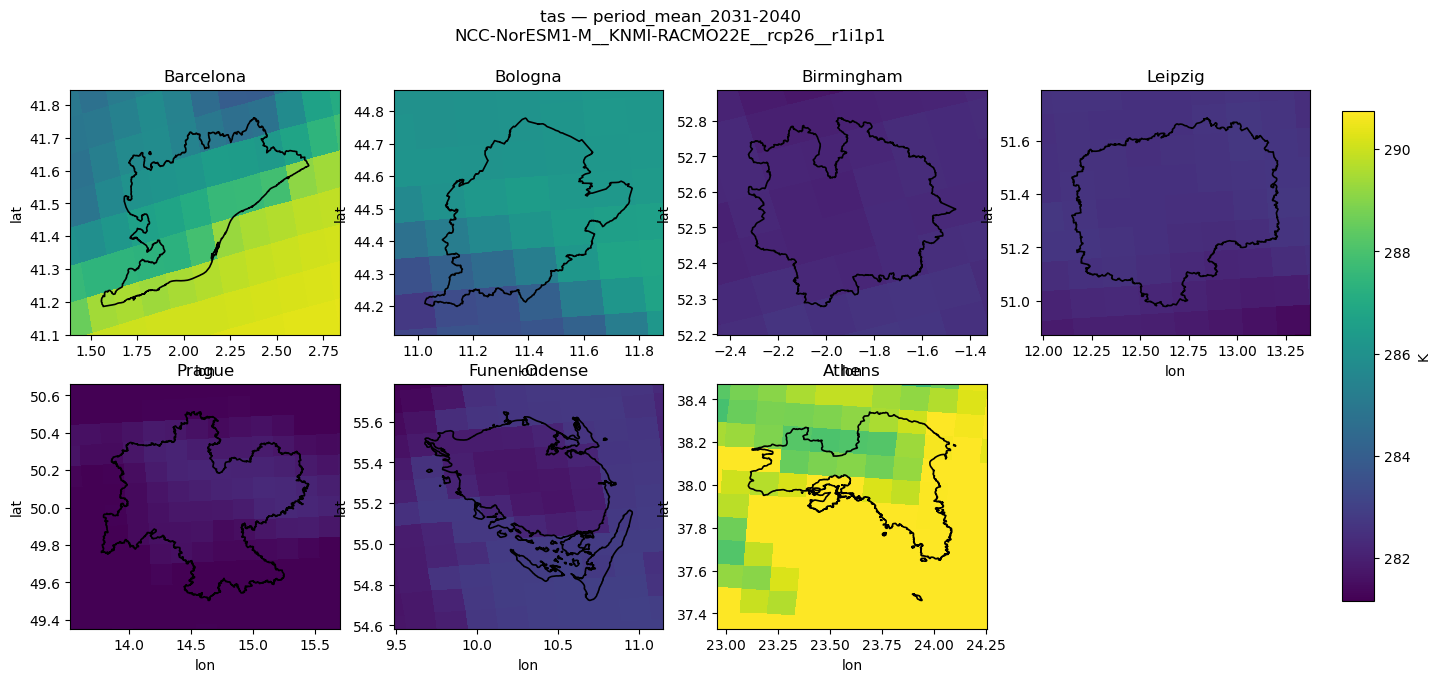

In [23]:
# =============================================================================
# PANEL PLOT — 7 CSAs (FUA zoom), one product + one model chain
# =============================================================================
from __future__ import annotations

from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings

# ---- USER CHOICE FOR THE PANEL ----
PANEL_PRODUCT = "period_mean_2031-2040"   # e.g. "period_mean_2031-2040" or "annual_mean"
PANEL_MODEL_FILTER = None                # substring to pick one model chain, e.g. "NCC-NorESM1-M"
CMAP = "viridis"                         # keep simple for now
ROBUST = True                            # use percentiles to avoid outliers dominating
PCTL = (2, 98)                           # robust scaling percentiles
ADD_BOUNDARY = True                      # overlay FUA boundary
DPI = 200

assert "results_df" in globals() and not results_df.empty, "results_df missing (run calculations)."

# --- helper: get lon/lat coord names and arrays ---
def get_lon_lat(da: xr.DataArray):
    for lon, lat in [("lon","lat"), ("longitude","latitude"), ("LON","LAT"), ("nav_lon","nav_lat")]:
        if lon in da.coords and lat in da.coords:
            return da[lon].values, da[lat].values
    return None, None

def dissolve_to_lonlat_polygon(csa: str):
    gdf = load_fua_boundary(csa)
    if gdf is None or gdf.empty:
        return None
    bg = gdf
    if getattr(bg, "crs", None) is not None:
        bg = bg.to_crs("EPSG:4326")
    return bg.geometry.union_all()

# --- pick one derived file matching product (+ optional model filter) ---
sub = results_df[results_df["product"] == PANEL_PRODUCT].copy()
if sub.empty:
    raise ValueError(f"No derived outputs for PANEL_PRODUCT='{PANEL_PRODUCT}'. "
                     f"Available: {sorted(results_df['product'].unique())}")

if PANEL_MODEL_FILTER is not None:
    sub = sub[sub["model_chain_id"].astype(str).str.contains(PANEL_MODEL_FILTER, case=False, na=False)].copy()
    if sub.empty:
        raise ValueError(f"No derived outputs match PANEL_MODEL_FILTER='{PANEL_MODEL_FILTER}'.")

# choose the first match (you can change this logic later)
picked = sub.iloc[0]
DERIVED_PATH = Path(picked["out_path"])
MODEL_ID = picked.get("model_chain_id")

print("Using derived file:", DERIVED_PATH.name)
print("Model chain:", MODEL_ID)

# --- load map (annual → pick first year for now) ---
ds = xr.open_dataset(DERIVED_PATH, decode_times=True)
try:
    da = ds[VAR_NAME].squeeze()
    year_val = None
    if "year" in da.dims:
        year_val = int(da["year"].values[0])
        da = da.isel(year=0)

    lon, lat = get_lon_lat(da)
    if lon is None or lat is None:
        raise RuntimeError("No lon/lat coordinates found in derived product. Needed for map plotting/zoom.")

    # --- compute shared color scale across all CSAs (based on each CSA-masked pixels) ---
    all_vals = []
    csa_polys = {}

    for csa in CSA_LIST:
        poly = dissolve_to_lonlat_polygon(csa)
        if poly is None:
            warnings.warn(f"Skip CSA={csa} (no polygon)")
            continue
        csa_polys[csa] = poly

        # mask values within polygon using shapely.vectorized
        from shapely import vectorized
        if lon.ndim == 1 and lat.ndim == 1:
            xx, yy = np.meshgrid(lon, lat)
            m = vectorized.contains(poly, xx, yy)
        else:
            m = vectorized.contains(poly, lon, lat)

        arr = np.asarray(da.values, dtype="float64")
        if m.shape == arr.shape and np.any(m):
            all_vals.append(arr[m])

    if not all_vals:
        raise RuntimeError("No CSA masks produced any values. Check polygons overlap lon/lat grid.")

    all_vals = np.concatenate(all_vals)
    all_vals = all_vals[np.isfinite(all_vals)]

    if ROBUST and all_vals.size > 0:
        vmin, vmax = np.percentile(all_vals, PCTL)
    else:
        vmin, vmax = float(np.nanmin(all_vals)), float(np.nanmax(all_vals))

    print("Color scale:", vmin, "to", vmax)

    # --- plot panel (7 CSAs) ---
    n = len(CSA_LIST)
    ncols = 4
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.5*nrows))
    axes = np.array(axes).reshape(-1)

    # store one im for shared colorbar
    im_last = None

    for i, csa in enumerate(CSA_LIST):
        ax = axes[i]
        poly = csa_polys.get(csa, None)
        if poly is None:
            ax.set_axis_off()
            ax.set_title(f"{csa} (no boundary)")
            continue

        arr = np.asarray(da.values, dtype="float64")

        # draw full map, then zoom to CSA bounds (simple + reliable)
        if lon.ndim == 1 and lat.ndim == 1:
            extent = [float(np.nanmin(lon)), float(np.nanmax(lon)),
                      float(np.nanmin(lat)), float(np.nanmax(lat))]
            im = ax.imshow(arr, origin="lower", extent=extent, cmap=CMAP, vmin=vmin, vmax=vmax)
        else:
            im = ax.pcolormesh(lon, lat, arr, shading="auto", cmap=CMAP, vmin=vmin, vmax=vmax)

        im_last = im

        # overlay boundary + zoom
        if ADD_BOUNDARY:
            try:
                x, y = poly.exterior.xy
                ax.plot(x, y, linewidth=1.2, color="black")
            except Exception:
                # multipolygons
                try:
                    for geom in getattr(poly, "geoms", []):
                        x, y = geom.exterior.xy
                        ax.plot(x, y, linewidth=1.2, color="black")
                except Exception as e:
                    warnings.warn(f"Boundary plot failed for {csa}: {e}")

        minx, miny, maxx, maxy = poly.bounds
        pad_x = (maxx - minx) * 0.15
        pad_y = (maxy - miny) * 0.15
        ax.set_xlim(minx - pad_x, maxx + pad_x)
        ax.set_ylim(miny - pad_y, maxy + pad_y)

        ax.set_title(csa)
        ax.set_xlabel("lon")
        ax.set_ylabel("lat")

    # turn off any unused axes
    for j in range(len(CSA_LIST), len(axes)):
        axes[j].set_axis_off()

    # shared colorbar
    # --- shared colorbar in dedicated axis ---
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(im_last, cax=cax)

    units = str(da.attrs.get("units", "")).strip()
    if units:
        cbar.set_label(units)


    sup = f"{VAR_NAME} — {PANEL_PRODUCT}"
    if year_val is not None:
        sup += f" (year={year_val})"
    sup += f"\n{MODEL_ID}"
    fig.suptitle(sup, y=0.995)

    #fig.tight_layout()

    out_png = EUROCORDEX_TEST_OUTPUT_ROOT / "plots" / "panel" / f"{VAR_NAME}_{PANEL_PRODUCT}_panel_{safe_slug(str(MODEL_ID))}.png"
    out_png.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_png, dpi=DPI, bbox_inches="tight")
    fig.subplots_adjust(right=0.9)
    print("Saved panel:", out_png)

    plt.show()

finally:
    ds.close()


Plotting: C:\Users\reinhvlr\OneDrive\CARMINE-T2.4\outputs\eurocordex_testing\derived\annual_mean\NCC-NorESM1-M__KNMI-RACMO22E__rcp26__r1i1p1\tas_annualmean_203101-204012.nc


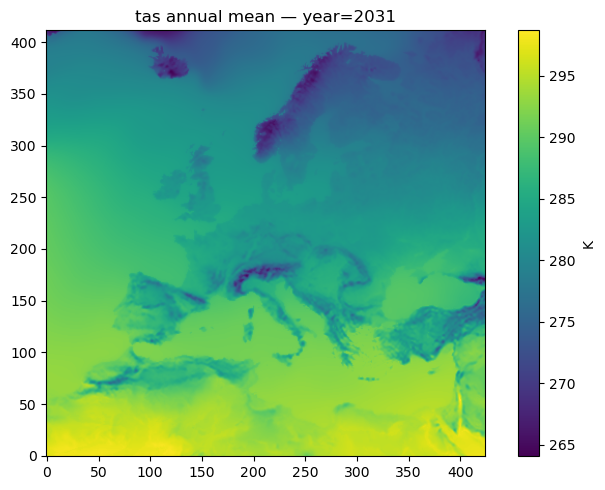

In [13]:
# =============================================================================
# SANITY PLOT — quick look at one derived product
# =============================================================================
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import numpy as np

assert "results_df" in globals() and not results_df.empty, "No derived outputs found."

# Pick first annual mean output by default (edit if you want)
pick = results_df[results_df["product"] == "annual_mean"].head(1)
if pick.empty:
    pick = results_df.head(1)

out_path = Path(pick.iloc[0]["out_path"])
print("Plotting:", out_path)

ds = xr.open_dataset(out_path)
da = ds[VAR_NAME]

# If annual_mean: pick first year slice to plot
if "year" in da.dims:
    da2 = da.isel(year=0)
    title = f"{VAR_NAME} annual mean — year={int(da['year'].values[0])}"
else:
    da2 = da
    title = f"{VAR_NAME} period mean"

arr = np.asarray(da2.values, dtype="float64")

plt.figure(figsize=(7, 5))
plt.imshow(arr, origin="lower")
plt.title(title)
plt.colorbar(label=str(da2.attrs.get("units", "")))
plt.tight_layout()
plt.show()